## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from mo-8dels import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
#!mkdir ./data
#!wget -P ./data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
#!unzip ./data/train-test-data.zip -d ./data

<div class="alert alert-info">**Note:** Workspaces preserve your available GPU time by closing the connection after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training.
</div>

In [2]:
# import requests
# response = requests.request("GET", "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", headers={"Metadata-Flavor":"Google"})
# token = response.text
# add the next line to run in each iteration of your main training loop
# requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})
# requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})

In [3]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F
## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import *
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# Perform data augmentation on train dataset by first scaling and then random cropping
data_transform = transforms.Compose([Rescale(250), \
                                           RandomCrop(224), \
                                           Normalize(), \
                                           ToTensor()])

assert(data_transform is not None, "Define a data_transform")

<ipython-input-5-69d813fcabcc>:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(data_transform is not None, "Define a data_transform")


In [6]:
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)

In [9]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
#         print("key_pts.shape:", key_pts.shape)
        # key_pts do not need to be wrapped until they are used for training

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
#     output_pts = net.forward(Variable(roi, volatile=True))
#         print("output_pts.size():", output_pts.size())
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [12]:
gt_pts

tensor([[[ 0.6873,  1.1350],
         [ 0.7433,  1.3867],
         [ 0.7433,  1.6104],
         ...,
         [ 1.4713,  2.2257],
         [ 1.3593,  2.2257],
         [ 1.3033,  2.2257]],

        [[ 0.2470,  1.2627],
         [ 0.3065,  1.5000],
         [ 0.3065,  1.7670],
         ...,
         [ 1.8244,  2.3603],
         [ 1.7649,  2.3603],
         [ 1.6458,  2.3603]],

        [[ 1.0679,  1.1733],
         [ 1.1269,  1.4100],
         [ 1.2743,  1.6172],
         ...,
         [ 2.3362,  1.8835],
         [ 2.2182,  1.9427],
         [ 2.0708,  1.9427]],

        ...,

        [[-0.0202,  0.4248],
         [-0.0202,  0.7852],
         [ 0.0829,  1.0427],
         ...,
         [ 1.9909,  2.5359],
         [ 1.8362,  2.5359],
         [ 1.7331,  2.5359]],

        [[ 0.7046,  0.5428],
         [ 0.7046,  0.8257],
         [ 0.7562,  1.0571],
         ...,
         [ 1.7618,  1.4429],
         [ 1.6586,  1.4943],
         [ 1.5297,  1.4429]],

        [[-0.0762,  1.1236],
       

In [13]:
test_outputs.data

tensor([[[-0.0127, -0.0232],
         [-0.0175,  0.0205],
         [ 0.0230, -0.0065],
         ...,
         [ 0.0030,  0.0243],
         [-0.0060, -0.0149],
         [ 0.0199,  0.0070]],

        [[-0.0141, -0.0233],
         [-0.0188,  0.0212],
         [ 0.0232, -0.0026],
         ...,
         [ 0.0024,  0.0220],
         [-0.0075, -0.0148],
         [ 0.0202,  0.0057]],

        [[-0.0155, -0.0253],
         [-0.0192,  0.0215],
         [ 0.0213, -0.0061],
         ...,
         [ 0.0021,  0.0227],
         [-0.0062, -0.0150],
         [ 0.0197,  0.0060]],

        ...,

        [[-0.0133, -0.0246],
         [-0.0207,  0.0207],
         [ 0.0233, -0.0046],
         ...,
         [ 0.0018,  0.0243],
         [-0.0063, -0.0142],
         [ 0.0197,  0.0057]],

        [[-0.0131, -0.0249],
         [-0.0169,  0.0207],
         [ 0.0232, -0.0060],
         ...,
         [ 0.0036,  0.0246],
         [-0.0059, -0.0164],
         [ 0.0182,  0.0072]],

        [[-0.0167, -0.0270],
       

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

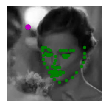

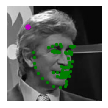

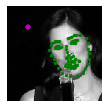

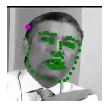

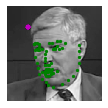

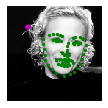

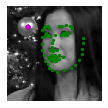

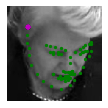

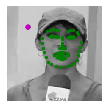

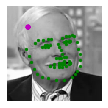

In [15]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
#     net.eval()
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
                
        # undo normalization of keypoints  
       # predicted_key_pts = predicted_key_pts*50.0+100
        predicted_key_pts = (predicted_key_pts * 48.0) + 48
    
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
#             ground_truth_pts = ground_truth_pts*50.0+100
            ground_truth_pts = ground_truth_pts * 48.0 + 48
    
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        
        plt.axis('off')
    
    
    plt.show()
    
# call it
# visualize_output(test_images, test_outputs, gt_pts)
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [16]:
import torch.optim as optim

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
def train_net(n_epochs):

    # Model in training mode, dropout is on
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
#             images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
#             if batch_i % 10 == 9:    # print every 10 batches
#                 print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10)) 
#                 running_loss = 0.0
            if batch_i % 40 == 39:    # print every 40 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i + 1, running_loss / 40)) 
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# train your network
n_epochs = 300 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 40, Avg. Loss: 2.4857245463877917
Epoch: 1, Batch: 80, Avg. Loss: 0.23730264231562614
Epoch: 1, Batch: 120, Avg. Loss: 0.2611624225974083
Epoch: 1, Batch: 160, Avg. Loss: 0.2019777812063694
Epoch: 1, Batch: 200, Avg. Loss: 0.2079387815669179
Epoch: 1, Batch: 240, Avg. Loss: 0.20463800746947527
Epoch: 1, Batch: 280, Avg. Loss: 0.23134953947737813
Epoch: 1, Batch: 320, Avg. Loss: 0.20936748590320348


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 40, Avg. Loss: 0.18104966469109057
Epoch: 2, Batch: 80, Avg. Loss: 0.20029221791774035
Epoch: 2, Batch: 120, Avg. Loss: 0.1974051358178258
Epoch: 2, Batch: 160, Avg. Loss: 0.209830498509109
Epoch: 2, Batch: 200, Avg. Loss: 0.16147850891575216
Epoch: 2, Batch: 240, Avg. Loss: 0.1897491393610835
Epoch: 2, Batch: 280, Avg. Loss: 0.16965212021023035
Epoch: 2, Batch: 320, Avg. Loss: 0.18141762539744377


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 40, Avg. Loss: 0.1644205655902624
Epoch: 3, Batch: 80, Avg. Loss: 0.17871187087148427
Epoch: 3, Batch: 120, Avg. Loss: 0.1572062077000737
Epoch: 3, Batch: 160, Avg. Loss: 0.15731946378946304
Epoch: 3, Batch: 200, Avg. Loss: 0.16961824037134648
Epoch: 3, Batch: 240, Avg. Loss: 0.15653410581871868
Epoch: 3, Batch: 280, Avg. Loss: 0.16685969643294812
Epoch: 3, Batch: 320, Avg. Loss: 0.1533347498625517


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 40, Avg. Loss: 0.17722569163888693
Epoch: 4, Batch: 80, Avg. Loss: 0.17258140165358782
Epoch: 4, Batch: 120, Avg. Loss: 0.15002809260040523
Epoch: 4, Batch: 160, Avg. Loss: 0.1563001809641719
Epoch: 4, Batch: 200, Avg. Loss: 0.14368285965174438
Epoch: 4, Batch: 240, Avg. Loss: 0.14852745104581117
Epoch: 4, Batch: 280, Avg. Loss: 0.15212990585714578
Epoch: 4, Batch: 320, Avg. Loss: 0.12443021833896636


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 40, Avg. Loss: 0.12223239000886679
Epoch: 5, Batch: 80, Avg. Loss: 0.13005092525854706
Epoch: 5, Batch: 120, Avg. Loss: 0.14405718119814992
Epoch: 5, Batch: 160, Avg. Loss: 0.11381841730326414
Epoch: 5, Batch: 200, Avg. Loss: 0.12509770337492226
Epoch: 5, Batch: 240, Avg. Loss: 0.13638503886759282
Epoch: 5, Batch: 280, Avg. Loss: 0.09040984958410263
Epoch: 5, Batch: 320, Avg. Loss: 0.08530549546703696


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 40, Avg. Loss: 0.10921336524188519
Epoch: 6, Batch: 80, Avg. Loss: 0.11062916303053498
Epoch: 6, Batch: 120, Avg. Loss: 0.093580515217036
Epoch: 6, Batch: 160, Avg. Loss: 0.09982740269042552
Epoch: 6, Batch: 200, Avg. Loss: 0.06876484816893935
Epoch: 6, Batch: 240, Avg. Loss: 0.07548446925356984
Epoch: 6, Batch: 280, Avg. Loss: 0.11018230710178614
Epoch: 6, Batch: 320, Avg. Loss: 0.10223292307928204


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 40, Avg. Loss: 0.11971230953931808
Epoch: 7, Batch: 80, Avg. Loss: 0.09641648102551699
Epoch: 7, Batch: 120, Avg. Loss: 0.08463041307404637
Epoch: 7, Batch: 160, Avg. Loss: 0.08710190737619997
Epoch: 7, Batch: 200, Avg. Loss: 0.08583283019252122
Epoch: 7, Batch: 240, Avg. Loss: 0.08346606334671378
Epoch: 7, Batch: 280, Avg. Loss: 0.06141857099719346
Epoch: 7, Batch: 320, Avg. Loss: 0.11730978405103087


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 40, Avg. Loss: 0.088894350733608
Epoch: 8, Batch: 80, Avg. Loss: 0.06777742970734835
Epoch: 8, Batch: 120, Avg. Loss: 0.06872080927714705
Epoch: 8, Batch: 160, Avg. Loss: 0.09972285707481206
Epoch: 8, Batch: 200, Avg. Loss: 0.08720153262838722
Epoch: 8, Batch: 240, Avg. Loss: 0.07682270002551377
Epoch: 8, Batch: 280, Avg. Loss: 0.06462228614836932
Epoch: 8, Batch: 320, Avg. Loss: 0.0730707089882344


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 40, Avg. Loss: 0.06113213398493826
Epoch: 9, Batch: 80, Avg. Loss: 0.06515207765623927
Epoch: 9, Batch: 120, Avg. Loss: 0.07143314429558814
Epoch: 9, Batch: 160, Avg. Loss: 0.09151767492294312
Epoch: 9, Batch: 200, Avg. Loss: 0.054275963176041844
Epoch: 9, Batch: 240, Avg. Loss: 0.05812886911444366
Epoch: 9, Batch: 280, Avg. Loss: 0.06685886993072927
Epoch: 9, Batch: 320, Avg. Loss: 0.08380380836315453


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 40, Avg. Loss: 0.05245251851156354
Epoch: 10, Batch: 80, Avg. Loss: 0.058231158275157215
Epoch: 10, Batch: 120, Avg. Loss: 0.06928485529497266
Epoch: 10, Batch: 160, Avg. Loss: 0.06513659562915564
Epoch: 10, Batch: 200, Avg. Loss: 0.06014719372615218
Epoch: 10, Batch: 240, Avg. Loss: 0.0522897238843143
Epoch: 10, Batch: 280, Avg. Loss: 0.046480994671583176
Epoch: 10, Batch: 320, Avg. Loss: 0.05178814511746168


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 40, Avg. Loss: 0.04372414047829807
Epoch: 11, Batch: 80, Avg. Loss: 0.06015537995845079
Epoch: 11, Batch: 120, Avg. Loss: 0.056803155969828364
Epoch: 11, Batch: 160, Avg. Loss: 0.03774534659460187
Epoch: 11, Batch: 200, Avg. Loss: 0.05533796902745962
Epoch: 11, Batch: 240, Avg. Loss: 0.06776734022423625
Epoch: 11, Batch: 280, Avg. Loss: 0.06551878424361349
Epoch: 11, Batch: 320, Avg. Loss: 0.05381897934712469


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 40, Avg. Loss: 0.06742767132818699
Epoch: 12, Batch: 80, Avg. Loss: 0.050531810615211725
Epoch: 12, Batch: 120, Avg. Loss: 0.055145909730345014
Epoch: 12, Batch: 160, Avg. Loss: 0.09376562060788274
Epoch: 12, Batch: 200, Avg. Loss: 0.048365013068541886
Epoch: 12, Batch: 240, Avg. Loss: 0.06001789725851268
Epoch: 12, Batch: 280, Avg. Loss: 0.0464626369997859
Epoch: 12, Batch: 320, Avg. Loss: 0.07503642146475613


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 40, Avg. Loss: 0.05356158269569278
Epoch: 13, Batch: 80, Avg. Loss: 0.06082052113488316
Epoch: 13, Batch: 120, Avg. Loss: 0.07308176006190478
Epoch: 13, Batch: 160, Avg. Loss: 0.09484031633473933
Epoch: 13, Batch: 200, Avg. Loss: 0.04006797098554671
Epoch: 13, Batch: 240, Avg. Loss: 0.04399127108044922
Epoch: 13, Batch: 280, Avg. Loss: 0.06303490030113608
Epoch: 13, Batch: 320, Avg. Loss: 0.059087206097319725


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 40, Avg. Loss: 0.04038529079407453
Epoch: 14, Batch: 80, Avg. Loss: 0.06337675964459777
Epoch: 14, Batch: 120, Avg. Loss: 0.05537255653180182
Epoch: 14, Batch: 160, Avg. Loss: 0.17914756648242475
Epoch: 14, Batch: 200, Avg. Loss: 0.039492122316733005
Epoch: 14, Batch: 240, Avg. Loss: 0.06676133438013494
Epoch: 14, Batch: 280, Avg. Loss: 0.04186540325172246
Epoch: 14, Batch: 320, Avg. Loss: 0.04777137227356434


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 40, Avg. Loss: 0.050939298258163034
Epoch: 15, Batch: 80, Avg. Loss: 0.0431740433908999
Epoch: 15, Batch: 120, Avg. Loss: 0.06476244064979256
Epoch: 15, Batch: 160, Avg. Loss: 0.06515244762413204
Epoch: 15, Batch: 200, Avg. Loss: 0.04099348345771432
Epoch: 15, Batch: 240, Avg. Loss: 0.03498032200150192
Epoch: 15, Batch: 280, Avg. Loss: 0.06504376295488327
Epoch: 15, Batch: 320, Avg. Loss: 0.03649880241136998


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 40, Avg. Loss: 0.033286192640662196
Epoch: 16, Batch: 80, Avg. Loss: 0.03002263274975121
Epoch: 16, Batch: 120, Avg. Loss: 0.037597792036831376
Epoch: 16, Batch: 160, Avg. Loss: 0.11127322283573449
Epoch: 16, Batch: 200, Avg. Loss: 0.06082406877540052
Epoch: 16, Batch: 240, Avg. Loss: 0.059421616280451416
Epoch: 16, Batch: 280, Avg. Loss: 0.05331530445255339
Epoch: 16, Batch: 320, Avg. Loss: 0.050218403339385986


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 40, Avg. Loss: 0.03559246847871691
Epoch: 17, Batch: 80, Avg. Loss: 0.06511914187576621
Epoch: 17, Batch: 120, Avg. Loss: 0.05033034281805158
Epoch: 17, Batch: 160, Avg. Loss: 0.03701172061264515
Epoch: 17, Batch: 200, Avg. Loss: 0.04239979917183519
Epoch: 17, Batch: 240, Avg. Loss: 0.06438935562036932
Epoch: 17, Batch: 280, Avg. Loss: 0.042919408367015424
Epoch: 17, Batch: 320, Avg. Loss: 0.05212771408259868


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 40, Avg. Loss: 0.03194701154716313
Epoch: 18, Batch: 80, Avg. Loss: 0.05210521137341857
Epoch: 18, Batch: 120, Avg. Loss: 0.03632720741443336
Epoch: 18, Batch: 160, Avg. Loss: 0.04011148486752063
Epoch: 18, Batch: 200, Avg. Loss: 0.03288921588100493
Epoch: 18, Batch: 240, Avg. Loss: 0.052747118496336044
Epoch: 18, Batch: 280, Avg. Loss: 0.029914984386414288
Epoch: 18, Batch: 320, Avg. Loss: 0.0260215078946203


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 40, Avg. Loss: 0.03424585501197726
Epoch: 19, Batch: 80, Avg. Loss: 0.03312495690770447
Epoch: 19, Batch: 120, Avg. Loss: 0.06695297788828611
Epoch: 19, Batch: 160, Avg. Loss: 0.033018881687894464
Epoch: 19, Batch: 200, Avg. Loss: 0.04247863169293851
Epoch: 19, Batch: 240, Avg. Loss: 0.04095634566619992
Epoch: 19, Batch: 280, Avg. Loss: 0.03404104157816619
Epoch: 19, Batch: 320, Avg. Loss: 0.0295844170730561


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 40, Avg. Loss: 0.06706319360528142
Epoch: 20, Batch: 80, Avg. Loss: 0.058582814829424026
Epoch: 20, Batch: 120, Avg. Loss: 0.036020757537335156
Epoch: 20, Batch: 160, Avg. Loss: 0.05486662280745804
Epoch: 20, Batch: 200, Avg. Loss: 0.058085439773276445
Epoch: 20, Batch: 240, Avg. Loss: 0.03990270404610783
Epoch: 20, Batch: 280, Avg. Loss: 0.03792409331072122
Epoch: 20, Batch: 320, Avg. Loss: 0.07335177469067275


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 40, Avg. Loss: 0.036611750000156464
Epoch: 21, Batch: 80, Avg. Loss: 0.04145615110173821
Epoch: 21, Batch: 120, Avg. Loss: 0.09232331747189164
Epoch: 21, Batch: 160, Avg. Loss: 0.04365931644570083
Epoch: 21, Batch: 200, Avg. Loss: 0.033995684958063065
Epoch: 21, Batch: 240, Avg. Loss: 0.038051154324784876
Epoch: 21, Batch: 280, Avg. Loss: 0.041666773869656025
Epoch: 21, Batch: 320, Avg. Loss: 0.04524789748247713


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 40, Avg. Loss: 0.026215618918649854
Epoch: 22, Batch: 80, Avg. Loss: 0.03323828119318932
Epoch: 22, Batch: 120, Avg. Loss: 0.04482272595632821
Epoch: 22, Batch: 160, Avg. Loss: 0.03468129020184278
Epoch: 22, Batch: 200, Avg. Loss: 0.07616766130086035
Epoch: 22, Batch: 240, Avg. Loss: 0.046602917625568806
Epoch: 22, Batch: 280, Avg. Loss: 0.0370573386317119
Epoch: 22, Batch: 320, Avg. Loss: 0.027252354845404624


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 40, Avg. Loss: 0.0358789284247905
Epoch: 23, Batch: 80, Avg. Loss: 0.03391108913347125
Epoch: 23, Batch: 120, Avg. Loss: 0.03530355996917933
Epoch: 23, Batch: 160, Avg. Loss: 0.04365879232063889
Epoch: 23, Batch: 200, Avg. Loss: 0.034876427496783435
Epoch: 23, Batch: 240, Avg. Loss: 0.02256278998684138
Epoch: 23, Batch: 280, Avg. Loss: 0.024863034416921437
Epoch: 23, Batch: 320, Avg. Loss: 0.03098322350997478


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 40, Avg. Loss: 0.033047141321003434
Epoch: 24, Batch: 80, Avg. Loss: 0.05933683968614787
Epoch: 24, Batch: 120, Avg. Loss: 0.10228553372435271
Epoch: 24, Batch: 160, Avg. Loss: 0.05299086580052972
Epoch: 24, Batch: 200, Avg. Loss: 0.03749172089155763
Epoch: 24, Batch: 240, Avg. Loss: 0.02726356666535139
Epoch: 24, Batch: 280, Avg. Loss: 0.024762321379967034
Epoch: 24, Batch: 320, Avg. Loss: 0.024004175327718258


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 40, Avg. Loss: 0.04522550478577614
Epoch: 25, Batch: 80, Avg. Loss: 0.027303218748420476
Epoch: 25, Batch: 120, Avg. Loss: 0.044196482910774645
Epoch: 25, Batch: 160, Avg. Loss: 0.059123767027631405
Epoch: 25, Batch: 200, Avg. Loss: 0.0297074573347345
Epoch: 25, Batch: 240, Avg. Loss: 0.04957307996228337
Epoch: 25, Batch: 280, Avg. Loss: 0.1065593725303188
Epoch: 25, Batch: 320, Avg. Loss: 0.02705694888718426


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 40, Avg. Loss: 0.02885633292607963
Epoch: 26, Batch: 80, Avg. Loss: 0.05498744018841535
Epoch: 26, Batch: 120, Avg. Loss: 0.023208141140639783
Epoch: 26, Batch: 160, Avg. Loss: 0.0248241210822016
Epoch: 26, Batch: 200, Avg. Loss: 0.02236370511818677
Epoch: 26, Batch: 240, Avg. Loss: 0.018819062004331498
Epoch: 26, Batch: 280, Avg. Loss: 0.03729340485297143
Epoch: 26, Batch: 320, Avg. Loss: 0.025910167163237928


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 40, Avg. Loss: 0.09913236058782786
Epoch: 27, Batch: 80, Avg. Loss: 0.02528520259074867
Epoch: 27, Batch: 120, Avg. Loss: 0.025753927789628504
Epoch: 27, Batch: 160, Avg. Loss: 0.033111812686547636
Epoch: 27, Batch: 200, Avg. Loss: 0.0339923424879089
Epoch: 27, Batch: 240, Avg. Loss: 0.022621190664358436
Epoch: 27, Batch: 280, Avg. Loss: 0.022389693884178996
Epoch: 27, Batch: 320, Avg. Loss: 0.02568664397113025


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 40, Avg. Loss: 0.026669041416607798
Epoch: 28, Batch: 80, Avg. Loss: 0.023909308097790925
Epoch: 28, Batch: 120, Avg. Loss: 0.028198690875433384
Epoch: 28, Batch: 160, Avg. Loss: 0.027436824422329663
Epoch: 28, Batch: 200, Avg. Loss: 0.033862633351236585
Epoch: 28, Batch: 240, Avg. Loss: 0.021852283645421265
Epoch: 28, Batch: 280, Avg. Loss: 0.019357999903149903
Epoch: 28, Batch: 320, Avg. Loss: 0.03022520066006109


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 40, Avg. Loss: 0.022220694622956217
Epoch: 29, Batch: 80, Avg. Loss: 0.03347336431033909
Epoch: 29, Batch: 120, Avg. Loss: 0.046516791149042544
Epoch: 29, Batch: 160, Avg. Loss: 0.026102854870259762
Epoch: 29, Batch: 200, Avg. Loss: 0.017779127811081707
Epoch: 29, Batch: 240, Avg. Loss: 0.049157708021812144
Epoch: 29, Batch: 280, Avg. Loss: 0.028571748407557607
Epoch: 29, Batch: 320, Avg. Loss: 0.030555187817662956


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 40, Avg. Loss: 0.04017259543761611
Epoch: 30, Batch: 80, Avg. Loss: 0.06647768940310925
Epoch: 30, Batch: 120, Avg. Loss: 0.024155898904427885
Epoch: 30, Batch: 160, Avg. Loss: 0.020528604392893612
Epoch: 30, Batch: 200, Avg. Loss: 0.01855826403480023
Epoch: 30, Batch: 240, Avg. Loss: 0.018845070037059486
Epoch: 30, Batch: 280, Avg. Loss: 0.018430317437741907
Epoch: 30, Batch: 320, Avg. Loss: 0.016913015930913388


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 40, Avg. Loss: 0.022809102572500704
Epoch: 31, Batch: 80, Avg. Loss: 0.025958239403553306
Epoch: 31, Batch: 120, Avg. Loss: 0.023882995918393136
Epoch: 31, Batch: 160, Avg. Loss: 0.051639218302443626
Epoch: 31, Batch: 200, Avg. Loss: 0.048914590221829715
Epoch: 31, Batch: 240, Avg. Loss: 0.10065157650969922
Epoch: 31, Batch: 280, Avg. Loss: 0.0464902549283579
Epoch: 31, Batch: 320, Avg. Loss: 0.025667671835981308


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 40, Avg. Loss: 0.030386072560213508
Epoch: 32, Batch: 80, Avg. Loss: 0.02898661505896598
Epoch: 32, Batch: 120, Avg. Loss: 0.028998973593115807
Epoch: 32, Batch: 160, Avg. Loss: 0.0343951873248443
Epoch: 32, Batch: 200, Avg. Loss: 0.021706287388224155
Epoch: 32, Batch: 240, Avg. Loss: 0.0756485408404842
Epoch: 32, Batch: 280, Avg. Loss: 0.029029996856115757
Epoch: 32, Batch: 320, Avg. Loss: 0.02120809108018875


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 40, Avg. Loss: 0.039657833287492394
Epoch: 33, Batch: 80, Avg. Loss: 0.020540339429862796
Epoch: 33, Batch: 120, Avg. Loss: 0.01926454729400575
Epoch: 33, Batch: 160, Avg. Loss: 0.022908470034599303
Epoch: 33, Batch: 200, Avg. Loss: 0.02276000918354839
Epoch: 33, Batch: 240, Avg. Loss: 0.024043170805089175
Epoch: 33, Batch: 280, Avg. Loss: 0.018873965728562325
Epoch: 33, Batch: 320, Avg. Loss: 0.019108647119719536


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 40, Avg. Loss: 0.015922488190699368
Epoch: 34, Batch: 80, Avg. Loss: 0.02621444386895746
Epoch: 34, Batch: 120, Avg. Loss: 0.018590207607485355
Epoch: 34, Batch: 160, Avg. Loss: 0.015850250062067063
Epoch: 34, Batch: 200, Avg. Loss: 0.01753394666593522
Epoch: 34, Batch: 240, Avg. Loss: 0.042073036055080594
Epoch: 34, Batch: 280, Avg. Loss: 0.0946938915643841
Epoch: 34, Batch: 320, Avg. Loss: 0.019101763889193536


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 40, Avg. Loss: 0.02790553905069828
Epoch: 35, Batch: 80, Avg. Loss: 0.02965893936343491
Epoch: 35, Batch: 120, Avg. Loss: 0.022377737914212048
Epoch: 35, Batch: 160, Avg. Loss: 0.025789192295633256
Epoch: 35, Batch: 200, Avg. Loss: 0.02113709836266935
Epoch: 35, Batch: 240, Avg. Loss: 0.02423182751517743
Epoch: 35, Batch: 280, Avg. Loss: 0.020667035039514302
Epoch: 35, Batch: 320, Avg. Loss: 0.01763909114524722


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 40, Avg. Loss: 0.041816689213737844
Epoch: 36, Batch: 80, Avg. Loss: 0.024542753328569235
Epoch: 36, Batch: 120, Avg. Loss: 0.02134272500406951
Epoch: 36, Batch: 160, Avg. Loss: 0.024358485406264663
Epoch: 36, Batch: 200, Avg. Loss: 0.08923063823021948
Epoch: 36, Batch: 240, Avg. Loss: 0.037014639982953665
Epoch: 36, Batch: 280, Avg. Loss: 0.024713622231502086
Epoch: 36, Batch: 320, Avg. Loss: 0.019168714596889912


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 40, Avg. Loss: 0.023604847537353636
Epoch: 37, Batch: 80, Avg. Loss: 0.01734216623008251
Epoch: 37, Batch: 120, Avg. Loss: 0.018402373394928874
Epoch: 37, Batch: 160, Avg. Loss: 0.019359430961776523
Epoch: 37, Batch: 200, Avg. Loss: 0.01844034652458504
Epoch: 37, Batch: 240, Avg. Loss: 0.02703906922833994
Epoch: 37, Batch: 280, Avg. Loss: 0.0164384959731251
Epoch: 37, Batch: 320, Avg. Loss: 0.017926705756690354


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 40, Avg. Loss: 0.06097633057506755
Epoch: 38, Batch: 80, Avg. Loss: 0.02148962498176843
Epoch: 38, Batch: 120, Avg. Loss: 0.019841393386013807
Epoch: 38, Batch: 160, Avg. Loss: 0.01647956930100918
Epoch: 38, Batch: 200, Avg. Loss: 0.02113814258482307
Epoch: 38, Batch: 240, Avg. Loss: 0.030757805448956788
Epoch: 38, Batch: 280, Avg. Loss: 0.019262884091585875
Epoch: 38, Batch: 320, Avg. Loss: 0.017805380956269802


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 40, Avg. Loss: 0.01933791385963559
Epoch: 39, Batch: 80, Avg. Loss: 0.03250013266224414
Epoch: 39, Batch: 120, Avg. Loss: 0.028302064642775803
Epoch: 39, Batch: 160, Avg. Loss: 0.020865567354485394
Epoch: 39, Batch: 200, Avg. Loss: 0.019613893958739935
Epoch: 39, Batch: 240, Avg. Loss: 0.06360455099493265
Epoch: 39, Batch: 280, Avg. Loss: 0.035078106075525285
Epoch: 39, Batch: 320, Avg. Loss: 0.01877293842844665


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 40, Avg. Loss: 0.05101379528641701
Epoch: 40, Batch: 80, Avg. Loss: 0.019442651385907082
Epoch: 40, Batch: 120, Avg. Loss: 0.01728502243058756
Epoch: 40, Batch: 160, Avg. Loss: 0.017410491418559104
Epoch: 40, Batch: 200, Avg. Loss: 0.034928346239030364
Epoch: 40, Batch: 240, Avg. Loss: 0.020567141403444112
Epoch: 40, Batch: 280, Avg. Loss: 0.019898609118536116
Epoch: 40, Batch: 320, Avg. Loss: 0.01390270417323336


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 40, Avg. Loss: 0.0371149648912251
Epoch: 41, Batch: 80, Avg. Loss: 0.0667116592056118
Epoch: 41, Batch: 120, Avg. Loss: 0.046073427447117864
Epoch: 41, Batch: 160, Avg. Loss: 0.026009206450544296
Epoch: 41, Batch: 200, Avg. Loss: 0.03951148397754878
Epoch: 41, Batch: 240, Avg. Loss: 0.027577150193974376
Epoch: 41, Batch: 280, Avg. Loss: 0.022528320993296803
Epoch: 41, Batch: 320, Avg. Loss: 0.01689120145747438


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 40, Avg. Loss: 0.024154372815974056
Epoch: 42, Batch: 80, Avg. Loss: 0.02476562508381903
Epoch: 42, Batch: 120, Avg. Loss: 0.08837108204606921
Epoch: 42, Batch: 160, Avg. Loss: 0.024932795995846392
Epoch: 42, Batch: 200, Avg. Loss: 0.025514610740356148
Epoch: 42, Batch: 240, Avg. Loss: 0.059972948092035946
Epoch: 42, Batch: 280, Avg. Loss: 0.03463654473889619
Epoch: 42, Batch: 320, Avg. Loss: 0.02990896173287183


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 40, Avg. Loss: 0.03662612100597471
Epoch: 43, Batch: 80, Avg. Loss: 0.020757287670858205
Epoch: 43, Batch: 120, Avg. Loss: 0.02054066746495664
Epoch: 43, Batch: 160, Avg. Loss: 0.03208407365018502
Epoch: 43, Batch: 200, Avg. Loss: 0.025291202426888048
Epoch: 43, Batch: 240, Avg. Loss: 0.017388880997896195
Epoch: 43, Batch: 280, Avg. Loss: 0.017552553629502653
Epoch: 43, Batch: 320, Avg. Loss: 0.016845026472583412


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 40, Avg. Loss: 0.03427932714112103
Epoch: 44, Batch: 80, Avg. Loss: 0.026776825240813196
Epoch: 44, Batch: 120, Avg. Loss: 0.029263729904778303
Epoch: 44, Batch: 160, Avg. Loss: 0.022968269931152464
Epoch: 44, Batch: 200, Avg. Loss: 0.018488122161943465
Epoch: 44, Batch: 240, Avg. Loss: 0.017933929059654474
Epoch: 44, Batch: 280, Avg. Loss: 0.014659513742662967
Epoch: 44, Batch: 320, Avg. Loss: 0.03895473557058722


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 40, Avg. Loss: 0.02696136066224426
Epoch: 45, Batch: 80, Avg. Loss: 0.020181447011418642
Epoch: 45, Batch: 120, Avg. Loss: 0.019219122477807105
Epoch: 45, Batch: 160, Avg. Loss: 0.029722756310366093
Epoch: 45, Batch: 200, Avg. Loss: 0.021800578432157637
Epoch: 45, Batch: 240, Avg. Loss: 0.016635922063142062
Epoch: 45, Batch: 280, Avg. Loss: 0.017198954126797616
Epoch: 45, Batch: 320, Avg. Loss: 0.016078017838299274


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 40, Avg. Loss: 0.026434062630869448
Epoch: 46, Batch: 80, Avg. Loss: 0.01868540041614324
Epoch: 46, Batch: 120, Avg. Loss: 0.01811765427701175
Epoch: 46, Batch: 160, Avg. Loss: 0.018154429679270834
Epoch: 46, Batch: 200, Avg. Loss: 0.019966134952846916
Epoch: 46, Batch: 240, Avg. Loss: 0.05859619213733822
Epoch: 46, Batch: 280, Avg. Loss: 0.01689578916411847
Epoch: 46, Batch: 320, Avg. Loss: 0.014492330863140524


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 40, Avg. Loss: 0.016607992444187404
Epoch: 47, Batch: 80, Avg. Loss: 0.032394870393909515
Epoch: 47, Batch: 120, Avg. Loss: 0.02617445478681475
Epoch: 47, Batch: 160, Avg. Loss: 0.019512319879140705
Epoch: 47, Batch: 200, Avg. Loss: 0.02853376481216401
Epoch: 47, Batch: 240, Avg. Loss: 0.021566215832717717
Epoch: 47, Batch: 280, Avg. Loss: 0.020480495365336537
Epoch: 47, Batch: 320, Avg. Loss: 0.0168610084336251


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 40, Avg. Loss: 0.024773961387109012
Epoch: 48, Batch: 80, Avg. Loss: 0.016784656140953303
Epoch: 48, Batch: 120, Avg. Loss: 0.017505694238934666
Epoch: 48, Batch: 160, Avg. Loss: 0.02809786373982206
Epoch: 48, Batch: 200, Avg. Loss: 0.020236002176534384
Epoch: 48, Batch: 240, Avg. Loss: 0.01574988695792854
Epoch: 48, Batch: 280, Avg. Loss: 0.017215598945040256
Epoch: 48, Batch: 320, Avg. Loss: 0.01794649219373241


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 40, Avg. Loss: 0.014310939726419747
Epoch: 49, Batch: 80, Avg. Loss: 0.018381031998433172
Epoch: 49, Batch: 120, Avg. Loss: 0.020381081697996704
Epoch: 49, Batch: 160, Avg. Loss: 0.015744598268065603
Epoch: 49, Batch: 200, Avg. Loss: 0.014634467696305364
Epoch: 49, Batch: 240, Avg. Loss: 0.013461662083864212
Epoch: 49, Batch: 280, Avg. Loss: 0.015413540147710592
Epoch: 49, Batch: 320, Avg. Loss: 0.01832930656382814


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 40, Avg. Loss: 0.032050007255747914
Epoch: 50, Batch: 80, Avg. Loss: 0.03742520343512297
Epoch: 50, Batch: 120, Avg. Loss: 0.01639597041066736
Epoch: 50, Batch: 160, Avg. Loss: 0.03610518106725067
Epoch: 50, Batch: 200, Avg. Loss: 0.07170082514639944
Epoch: 50, Batch: 240, Avg. Loss: 0.0354353480739519
Epoch: 50, Batch: 280, Avg. Loss: 0.020907980855554342
Epoch: 50, Batch: 320, Avg. Loss: 0.019032669544685632


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 51, Batch: 40, Avg. Loss: 0.016943394497502595
Epoch: 51, Batch: 80, Avg. Loss: 0.027929290710017086
Epoch: 51, Batch: 120, Avg. Loss: 0.020494767208583654
Epoch: 51, Batch: 160, Avg. Loss: 0.018880315613932906
Epoch: 51, Batch: 200, Avg. Loss: 0.02210674489615485
Epoch: 51, Batch: 240, Avg. Loss: 0.019037125795148314
Epoch: 51, Batch: 280, Avg. Loss: 0.012697134260088205
Epoch: 51, Batch: 320, Avg. Loss: 0.022467617073561996


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 52, Batch: 40, Avg. Loss: 0.016811751923523844
Epoch: 52, Batch: 80, Avg. Loss: 0.024921183427795767
Epoch: 52, Batch: 120, Avg. Loss: 0.020932487084064633
Epoch: 52, Batch: 160, Avg. Loss: 0.016774613549932836
Epoch: 52, Batch: 200, Avg. Loss: 0.07554275835864246
Epoch: 52, Batch: 240, Avg. Loss: 0.03930030686315149
Epoch: 52, Batch: 280, Avg. Loss: 0.01761786120478064
Epoch: 52, Batch: 320, Avg. Loss: 0.022847605030983688


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 53, Batch: 40, Avg. Loss: 0.019045729062054307
Epoch: 53, Batch: 80, Avg. Loss: 0.015847134054638445
Epoch: 53, Batch: 120, Avg. Loss: 0.017526855948381125
Epoch: 53, Batch: 160, Avg. Loss: 0.018975895759649575
Epoch: 53, Batch: 200, Avg. Loss: 0.019033522321842612
Epoch: 53, Batch: 240, Avg. Loss: 0.04752908232621848
Epoch: 53, Batch: 280, Avg. Loss: 0.018797216610983013
Epoch: 53, Batch: 320, Avg. Loss: 0.016871575417462738


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 54, Batch: 40, Avg. Loss: 0.01655224177520722
Epoch: 54, Batch: 80, Avg. Loss: 0.019541899592150004
Epoch: 54, Batch: 120, Avg. Loss: 0.02619923127349466
Epoch: 54, Batch: 160, Avg. Loss: 0.019527505547739566
Epoch: 54, Batch: 200, Avg. Loss: 0.023595315322745593
Epoch: 54, Batch: 240, Avg. Loss: 0.01657893875380978
Epoch: 54, Batch: 280, Avg. Loss: 0.03194040401140228
Epoch: 54, Batch: 320, Avg. Loss: 0.02840973313432187


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 55, Batch: 40, Avg. Loss: 0.014689939969684929
Epoch: 55, Batch: 80, Avg. Loss: 0.01651938247960061
Epoch: 55, Batch: 120, Avg. Loss: 0.017519671097397806
Epoch: 55, Batch: 160, Avg. Loss: 0.029633772384840995
Epoch: 55, Batch: 200, Avg. Loss: 0.018031611118931323
Epoch: 55, Batch: 240, Avg. Loss: 0.01784481215290725
Epoch: 55, Batch: 280, Avg. Loss: 0.015862337313592434
Epoch: 55, Batch: 320, Avg. Loss: 0.03398205905687064


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 56, Batch: 40, Avg. Loss: 0.016302654088940473
Epoch: 56, Batch: 80, Avg. Loss: 0.01576444027014077
Epoch: 56, Batch: 120, Avg. Loss: 0.01570454288739711
Epoch: 56, Batch: 160, Avg. Loss: 0.014535695582162588
Epoch: 56, Batch: 200, Avg. Loss: 0.020064482546877115
Epoch: 56, Batch: 240, Avg. Loss: 0.0202579808072187
Epoch: 56, Batch: 280, Avg. Loss: 0.02143360278569162
Epoch: 56, Batch: 320, Avg. Loss: 0.016621542524080723


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 57, Batch: 40, Avg. Loss: 0.012837564724031835
Epoch: 57, Batch: 80, Avg. Loss: 0.02473016905132681
Epoch: 57, Batch: 120, Avg. Loss: 0.017374841403216122
Epoch: 57, Batch: 160, Avg. Loss: 0.022134185605682432
Epoch: 57, Batch: 200, Avg. Loss: 0.01983260434353724
Epoch: 57, Batch: 240, Avg. Loss: 0.013696370366960763
Epoch: 57, Batch: 280, Avg. Loss: 0.014304243202786893
Epoch: 57, Batch: 320, Avg. Loss: 0.01864642057335004


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 58, Batch: 40, Avg. Loss: 0.01808059699833393
Epoch: 58, Batch: 80, Avg. Loss: 0.019189623510465027
Epoch: 58, Batch: 120, Avg. Loss: 0.06180439214222133
Epoch: 58, Batch: 160, Avg. Loss: 0.026866260333918035
Epoch: 58, Batch: 200, Avg. Loss: 0.0185839292826131
Epoch: 58, Batch: 240, Avg. Loss: 0.02164699146524072
Epoch: 58, Batch: 280, Avg. Loss: 0.021681182878091933
Epoch: 58, Batch: 320, Avg. Loss: 0.018379072472453118


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 59, Batch: 40, Avg. Loss: 0.014619067753665149
Epoch: 59, Batch: 80, Avg. Loss: 0.02703226275043562
Epoch: 59, Batch: 120, Avg. Loss: 0.01738703013397753
Epoch: 59, Batch: 160, Avg. Loss: 0.03811561483889818
Epoch: 59, Batch: 200, Avg. Loss: 0.025841404777020217
Epoch: 59, Batch: 240, Avg. Loss: 0.02481449762126431
Epoch: 59, Batch: 280, Avg. Loss: 0.015095978428144008
Epoch: 59, Batch: 320, Avg. Loss: 0.020507526688743383


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 60, Batch: 40, Avg. Loss: 0.038183496636338535
Epoch: 60, Batch: 80, Avg. Loss: 0.018865512823686002
Epoch: 60, Batch: 120, Avg. Loss: 0.019024129188619555
Epoch: 60, Batch: 160, Avg. Loss: 0.02082884139381349
Epoch: 60, Batch: 200, Avg. Loss: 0.015235546696931123
Epoch: 60, Batch: 240, Avg. Loss: 0.05202682767994702
Epoch: 60, Batch: 280, Avg. Loss: 0.033447932451963425
Epoch: 60, Batch: 320, Avg. Loss: 0.023670964385382832


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 61, Batch: 40, Avg. Loss: 0.049477417254820466
Epoch: 61, Batch: 80, Avg. Loss: 0.04645034405402839
Epoch: 61, Batch: 120, Avg. Loss: 0.020030433731153607
Epoch: 61, Batch: 160, Avg. Loss: 0.016780573478899895
Epoch: 61, Batch: 200, Avg. Loss: 0.019402796134818344
Epoch: 61, Batch: 240, Avg. Loss: 0.01623223110800609
Epoch: 61, Batch: 280, Avg. Loss: 0.015811496472451836
Epoch: 61, Batch: 320, Avg. Loss: 0.015827305789571255


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 62, Batch: 40, Avg. Loss: 0.021217987092677505
Epoch: 62, Batch: 80, Avg. Loss: 0.022363837459124625
Epoch: 62, Batch: 120, Avg. Loss: 0.014514864073134959
Epoch: 62, Batch: 160, Avg. Loss: 0.025394243688788266
Epoch: 62, Batch: 200, Avg. Loss: 0.017669877992011605
Epoch: 62, Batch: 240, Avg. Loss: 0.015008970524650066
Epoch: 62, Batch: 280, Avg. Loss: 0.015818656934425235
Epoch: 62, Batch: 320, Avg. Loss: 0.012339091405738144


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 63, Batch: 40, Avg. Loss: 0.014206829632166773
Epoch: 63, Batch: 80, Avg. Loss: 0.017363830690737814
Epoch: 63, Batch: 120, Avg. Loss: 0.01395097451750189
Epoch: 63, Batch: 160, Avg. Loss: 0.015571597591042518
Epoch: 63, Batch: 200, Avg. Loss: 0.02072653662180528
Epoch: 63, Batch: 240, Avg. Loss: 0.014159631403163075
Epoch: 63, Batch: 280, Avg. Loss: 0.03224856317974627
Epoch: 63, Batch: 320, Avg. Loss: 0.019037897302769124


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 64, Batch: 40, Avg. Loss: 0.018458225612994282
Epoch: 64, Batch: 80, Avg. Loss: 0.017982021474745126
Epoch: 64, Batch: 120, Avg. Loss: 0.02486500854138285
Epoch: 64, Batch: 160, Avg. Loss: 0.012987777870148421
Epoch: 64, Batch: 200, Avg. Loss: 0.013524284516461194
Epoch: 64, Batch: 240, Avg. Loss: 0.01288090816233307
Epoch: 64, Batch: 280, Avg. Loss: 0.014664745738264174
Epoch: 64, Batch: 320, Avg. Loss: 0.013214644126128406


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 65, Batch: 40, Avg. Loss: 0.014822179824113846
Epoch: 65, Batch: 80, Avg. Loss: 0.015488134964834898
Epoch: 65, Batch: 120, Avg. Loss: 0.011994074215181172
Epoch: 65, Batch: 160, Avg. Loss: 0.09583609196124598
Epoch: 65, Batch: 200, Avg. Loss: 0.025852395780384542
Epoch: 65, Batch: 240, Avg. Loss: 0.01596123545896262
Epoch: 65, Batch: 280, Avg. Loss: 0.015864574641454965
Epoch: 65, Batch: 320, Avg. Loss: 0.02011581223923713


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 66, Batch: 40, Avg. Loss: 0.018488536728546022
Epoch: 66, Batch: 80, Avg. Loss: 0.015557430847547949
Epoch: 66, Batch: 120, Avg. Loss: 0.02642039485508576
Epoch: 66, Batch: 160, Avg. Loss: 0.02559747735504061
Epoch: 66, Batch: 200, Avg. Loss: 0.01615897798910737
Epoch: 66, Batch: 240, Avg. Loss: 0.016037323279306293
Epoch: 66, Batch: 280, Avg. Loss: 0.01663131343666464
Epoch: 66, Batch: 320, Avg. Loss: 0.019337275065481663


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 67, Batch: 40, Avg. Loss: 0.0147515989956446
Epoch: 67, Batch: 80, Avg. Loss: 0.017635701317340137
Epoch: 67, Batch: 120, Avg. Loss: 0.012632626271806658
Epoch: 67, Batch: 160, Avg. Loss: 0.012728418817277997
Epoch: 67, Batch: 200, Avg. Loss: 0.02937849760055542
Epoch: 67, Batch: 240, Avg. Loss: 0.03002144452184439
Epoch: 67, Batch: 280, Avg. Loss: 0.02725633264053613
Epoch: 67, Batch: 320, Avg. Loss: 0.019628316815942525


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 68, Batch: 40, Avg. Loss: 0.01725075513822958
Epoch: 68, Batch: 80, Avg. Loss: 0.01388804338639602
Epoch: 68, Batch: 120, Avg. Loss: 0.016104902827646584
Epoch: 68, Batch: 160, Avg. Loss: 0.021776323905214667
Epoch: 68, Batch: 200, Avg. Loss: 0.03428814320359379
Epoch: 68, Batch: 240, Avg. Loss: 0.029560298938304187
Epoch: 68, Batch: 280, Avg. Loss: 0.03197065144777298
Epoch: 68, Batch: 320, Avg. Loss: 0.021758085628971458


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 69, Batch: 40, Avg. Loss: 0.01546304242219776
Epoch: 69, Batch: 80, Avg. Loss: 0.022399129485711454
Epoch: 69, Batch: 120, Avg. Loss: 0.01642119757598266
Epoch: 69, Batch: 160, Avg. Loss: 0.01538357549579814
Epoch: 69, Batch: 200, Avg. Loss: 0.014516523643396794
Epoch: 69, Batch: 240, Avg. Loss: 0.021478226804174484
Epoch: 69, Batch: 280, Avg. Loss: 0.024272565986029802
Epoch: 69, Batch: 320, Avg. Loss: 0.022061602701433


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 70, Batch: 40, Avg. Loss: 0.01700046481564641
Epoch: 70, Batch: 80, Avg. Loss: 0.020637775759678335
Epoch: 70, Batch: 120, Avg. Loss: 0.01566358036361635
Epoch: 70, Batch: 160, Avg. Loss: 0.013173474790528416
Epoch: 70, Batch: 200, Avg. Loss: 0.020348930498585105
Epoch: 70, Batch: 240, Avg. Loss: 0.03403594810515642
Epoch: 70, Batch: 280, Avg. Loss: 0.060224248515442017
Epoch: 70, Batch: 320, Avg. Loss: 0.017885774897877127


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 71, Batch: 40, Avg. Loss: 0.024392648378852754
Epoch: 71, Batch: 80, Avg. Loss: 0.025630314694717528
Epoch: 71, Batch: 120, Avg. Loss: 0.023891491885297
Epoch: 71, Batch: 160, Avg. Loss: 0.01627311990596354
Epoch: 71, Batch: 200, Avg. Loss: 0.013633548573125154
Epoch: 71, Batch: 240, Avg. Loss: 0.013810858933720738
Epoch: 71, Batch: 280, Avg. Loss: 0.019000601256266236
Epoch: 71, Batch: 320, Avg. Loss: 0.025831945973914118


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 72, Batch: 40, Avg. Loss: 0.020032469078432768
Epoch: 72, Batch: 80, Avg. Loss: 0.039389743888750675
Epoch: 72, Batch: 120, Avg. Loss: 0.020079644024372102
Epoch: 72, Batch: 160, Avg. Loss: 0.016867143043782562
Epoch: 72, Batch: 200, Avg. Loss: 0.027715486160013826
Epoch: 72, Batch: 240, Avg. Loss: 0.03634164640679956
Epoch: 72, Batch: 280, Avg. Loss: 0.03194186093751341
Epoch: 72, Batch: 320, Avg. Loss: 0.02432317698840052


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 73, Batch: 40, Avg. Loss: 0.018993986840359866
Epoch: 73, Batch: 80, Avg. Loss: 0.018038059026002883
Epoch: 73, Batch: 120, Avg. Loss: 0.017876595386769622
Epoch: 73, Batch: 160, Avg. Loss: 0.018110635923221707
Epoch: 73, Batch: 200, Avg. Loss: 0.022463059704750776
Epoch: 73, Batch: 240, Avg. Loss: 0.019773063773754984
Epoch: 73, Batch: 280, Avg. Loss: 0.017449908400885762
Epoch: 73, Batch: 320, Avg. Loss: 0.013531246269121767


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 74, Batch: 40, Avg. Loss: 0.014542103838175535
Epoch: 74, Batch: 80, Avg. Loss: 0.02413096415111795
Epoch: 74, Batch: 120, Avg. Loss: 0.017312766041141004
Epoch: 74, Batch: 160, Avg. Loss: 0.01591492196312174
Epoch: 74, Batch: 200, Avg. Loss: 0.01743484182516113
Epoch: 74, Batch: 240, Avg. Loss: 0.012069975945632905
Epoch: 74, Batch: 280, Avg. Loss: 0.014670480671338738
Epoch: 74, Batch: 320, Avg. Loss: 0.015906410734169187


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 75, Batch: 40, Avg. Loss: 0.011600117408670485
Epoch: 75, Batch: 80, Avg. Loss: 0.016189080534968526
Epoch: 75, Batch: 120, Avg. Loss: 0.01343669651541859
Epoch: 75, Batch: 160, Avg. Loss: 0.012522595946211367
Epoch: 75, Batch: 200, Avg. Loss: 0.012724459660239518
Epoch: 75, Batch: 240, Avg. Loss: 0.011139472445938737
Epoch: 75, Batch: 280, Avg. Loss: 0.014008838473819197
Epoch: 75, Batch: 320, Avg. Loss: 0.014119815756566822


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 76, Batch: 40, Avg. Loss: 0.011932957253884524
Epoch: 76, Batch: 80, Avg. Loss: 0.011861323239281773
Epoch: 76, Batch: 120, Avg. Loss: 0.02192953818012029
Epoch: 76, Batch: 160, Avg. Loss: 0.01809784135548398
Epoch: 76, Batch: 200, Avg. Loss: 0.014363743062131108
Epoch: 76, Batch: 240, Avg. Loss: 0.013774172938428818
Epoch: 76, Batch: 280, Avg. Loss: 0.012114495423156768
Epoch: 76, Batch: 320, Avg. Loss: 0.01778093263274059


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 77, Batch: 40, Avg. Loss: 0.01424163457704708
Epoch: 77, Batch: 80, Avg. Loss: 0.014616931753698737
Epoch: 77, Batch: 120, Avg. Loss: 0.012265430169645698
Epoch: 77, Batch: 160, Avg. Loss: 0.014329799951519817
Epoch: 77, Batch: 200, Avg. Loss: 0.020331544568762183
Epoch: 77, Batch: 240, Avg. Loss: 0.01777786499587819
Epoch: 77, Batch: 280, Avg. Loss: 0.01710628521395847
Epoch: 77, Batch: 320, Avg. Loss: 0.014168002922087908


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 78, Batch: 40, Avg. Loss: 0.012946702318731695
Epoch: 78, Batch: 80, Avg. Loss: 0.016988257830962538
Epoch: 78, Batch: 120, Avg. Loss: 0.01175538229290396
Epoch: 78, Batch: 160, Avg. Loss: 0.012551252974662929
Epoch: 78, Batch: 200, Avg. Loss: 0.01854466974036768
Epoch: 78, Batch: 240, Avg. Loss: 0.012495141371618956
Epoch: 78, Batch: 280, Avg. Loss: 0.02010932614794001
Epoch: 78, Batch: 320, Avg. Loss: 0.018652760225813837


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 79, Batch: 40, Avg. Loss: 0.012712715950328857
Epoch: 79, Batch: 80, Avg. Loss: 0.013333186611998827
Epoch: 79, Batch: 120, Avg. Loss: 0.0167375672259368
Epoch: 79, Batch: 160, Avg. Loss: 0.016628200432751327
Epoch: 79, Batch: 200, Avg. Loss: 0.01734410976059735
Epoch: 79, Batch: 240, Avg. Loss: 0.01162738372804597
Epoch: 79, Batch: 280, Avg. Loss: 0.015411953954026104
Epoch: 79, Batch: 320, Avg. Loss: 0.01846082790289074


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 80, Batch: 40, Avg. Loss: 0.0329548095818609
Epoch: 80, Batch: 80, Avg. Loss: 0.028795640426687898
Epoch: 80, Batch: 120, Avg. Loss: 0.019846090965438636
Epoch: 80, Batch: 160, Avg. Loss: 0.018305009498726578
Epoch: 80, Batch: 200, Avg. Loss: 0.015338346699718387
Epoch: 80, Batch: 240, Avg. Loss: 0.012969390104990453
Epoch: 80, Batch: 280, Avg. Loss: 0.013567095960024745
Epoch: 80, Batch: 320, Avg. Loss: 0.017370952828787267


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 81, Batch: 40, Avg. Loss: 0.040677726920694116
Epoch: 81, Batch: 80, Avg. Loss: 0.02355105618480593
Epoch: 81, Batch: 120, Avg. Loss: 0.017042677896097303
Epoch: 81, Batch: 160, Avg. Loss: 0.014222838147543371
Epoch: 81, Batch: 200, Avg. Loss: 0.021529953728895636
Epoch: 81, Batch: 240, Avg. Loss: 0.014606722316239029
Epoch: 81, Batch: 280, Avg. Loss: 0.013947084976825863
Epoch: 81, Batch: 320, Avg. Loss: 0.011580238211899995


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 82, Batch: 40, Avg. Loss: 0.01443114229477942
Epoch: 82, Batch: 80, Avg. Loss: 0.01285070824669674
Epoch: 82, Batch: 120, Avg. Loss: 0.03395302938297391
Epoch: 82, Batch: 160, Avg. Loss: 0.014742308575659991
Epoch: 82, Batch: 200, Avg. Loss: 0.012156417965888977
Epoch: 82, Batch: 240, Avg. Loss: 0.02611520994687453
Epoch: 82, Batch: 280, Avg. Loss: 0.02275486965663731
Epoch: 82, Batch: 320, Avg. Loss: 0.017487551318481565


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 83, Batch: 40, Avg. Loss: 0.0130735884886235
Epoch: 83, Batch: 80, Avg. Loss: 0.013101103052031248
Epoch: 83, Batch: 120, Avg. Loss: 0.03866317233769223
Epoch: 83, Batch: 160, Avg. Loss: 0.03764975089579821
Epoch: 83, Batch: 200, Avg. Loss: 0.026681616925634442
Epoch: 83, Batch: 240, Avg. Loss: 0.021609008312225342
Epoch: 83, Batch: 280, Avg. Loss: 0.018614230304956438
Epoch: 83, Batch: 320, Avg. Loss: 0.011291799414902926


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 84, Batch: 40, Avg. Loss: 0.0112844722927548
Epoch: 84, Batch: 80, Avg. Loss: 0.014293154317419976
Epoch: 84, Batch: 120, Avg. Loss: 0.01425468255765736
Epoch: 84, Batch: 160, Avg. Loss: 0.012661356350872666
Epoch: 84, Batch: 200, Avg. Loss: 0.012009292212314903
Epoch: 84, Batch: 240, Avg. Loss: 0.034280180057976395
Epoch: 84, Batch: 280, Avg. Loss: 0.013757365650963038
Epoch: 84, Batch: 320, Avg. Loss: 0.012059936334844678


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 85, Batch: 40, Avg. Loss: 0.01354675559559837
Epoch: 85, Batch: 80, Avg. Loss: 0.014462813385762274
Epoch: 85, Batch: 120, Avg. Loss: 0.016566608322318644
Epoch: 85, Batch: 160, Avg. Loss: 0.019183058582711965
Epoch: 85, Batch: 200, Avg. Loss: 0.014916200295556337
Epoch: 85, Batch: 240, Avg. Loss: 0.01394904328044504
Epoch: 85, Batch: 280, Avg. Loss: 0.010512595355976373
Epoch: 85, Batch: 320, Avg. Loss: 0.016602526127826422


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 86, Batch: 40, Avg. Loss: 0.01408254138659686
Epoch: 86, Batch: 80, Avg. Loss: 0.015240862360224127
Epoch: 86, Batch: 120, Avg. Loss: 0.012489890994038433
Epoch: 86, Batch: 160, Avg. Loss: 0.012868864263873547
Epoch: 86, Batch: 200, Avg. Loss: 0.015358878753613681
Epoch: 86, Batch: 240, Avg. Loss: 0.01324320441344753
Epoch: 86, Batch: 280, Avg. Loss: 0.011827318160794676
Epoch: 86, Batch: 320, Avg. Loss: 0.012026318511925638


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 87, Batch: 40, Avg. Loss: 0.009801076375879347
Epoch: 87, Batch: 80, Avg. Loss: 0.012022866308689118
Epoch: 87, Batch: 120, Avg. Loss: 0.010457878850866109
Epoch: 87, Batch: 160, Avg. Loss: 0.00975405341014266
Epoch: 87, Batch: 200, Avg. Loss: 0.009202369605191052
Epoch: 87, Batch: 240, Avg. Loss: 0.011584458360448479
Epoch: 87, Batch: 280, Avg. Loss: 0.011597094859462231
Epoch: 87, Batch: 320, Avg. Loss: 0.012423000286798925


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 88, Batch: 40, Avg. Loss: 0.010187340446282177
Epoch: 88, Batch: 80, Avg. Loss: 0.013680931064300239
Epoch: 88, Batch: 120, Avg. Loss: 0.013464962632860988
Epoch: 88, Batch: 160, Avg. Loss: 0.011637490976136177
Epoch: 88, Batch: 200, Avg. Loss: 0.021614482311997564
Epoch: 88, Batch: 240, Avg. Loss: 0.017655229358933867
Epoch: 88, Batch: 280, Avg. Loss: 0.012081008404493332
Epoch: 88, Batch: 320, Avg. Loss: 0.011827745661139488


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 89, Batch: 40, Avg. Loss: 0.012436537083704024
Epoch: 89, Batch: 80, Avg. Loss: 0.011141817516181618
Epoch: 89, Batch: 120, Avg. Loss: 0.010064086026977748
Epoch: 89, Batch: 160, Avg. Loss: 0.015623232978396118
Epoch: 89, Batch: 200, Avg. Loss: 0.014327347150538117
Epoch: 89, Batch: 240, Avg. Loss: 0.026187249319627882
Epoch: 89, Batch: 280, Avg. Loss: 0.01843815154861659
Epoch: 89, Batch: 320, Avg. Loss: 0.017482880828902127


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 90, Batch: 40, Avg. Loss: 0.012627662997692824
Epoch: 90, Batch: 80, Avg. Loss: 0.012153802160173654
Epoch: 90, Batch: 120, Avg. Loss: 0.013171483972109854
Epoch: 90, Batch: 160, Avg. Loss: 0.013260279619134962
Epoch: 90, Batch: 200, Avg. Loss: 0.010840262460988015
Epoch: 90, Batch: 240, Avg. Loss: 0.01134589664870873
Epoch: 90, Batch: 280, Avg. Loss: 0.014144981116987764
Epoch: 90, Batch: 320, Avg. Loss: 0.011463606671895832


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 91, Batch: 40, Avg. Loss: 0.011512818990740924
Epoch: 91, Batch: 80, Avg. Loss: 0.011748122947756201
Epoch: 91, Batch: 120, Avg. Loss: 0.010412713314872235
Epoch: 91, Batch: 160, Avg. Loss: 0.01793708064360544
Epoch: 91, Batch: 200, Avg. Loss: 0.02113983577582985
Epoch: 91, Batch: 240, Avg. Loss: 0.019932095531839878
Epoch: 91, Batch: 280, Avg. Loss: 0.015436324418988078
Epoch: 91, Batch: 320, Avg. Loss: 0.016946100012864916


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 92, Batch: 40, Avg. Loss: 0.0902378928847611
Epoch: 92, Batch: 80, Avg. Loss: 0.037268322077579796
Epoch: 92, Batch: 120, Avg. Loss: 0.022149280994199216
Epoch: 92, Batch: 160, Avg. Loss: 0.019999934721272438
Epoch: 92, Batch: 200, Avg. Loss: 0.03496507159434259
Epoch: 92, Batch: 240, Avg. Loss: 0.015239359252154827
Epoch: 92, Batch: 280, Avg. Loss: 0.01204750023316592
Epoch: 92, Batch: 320, Avg. Loss: 0.011788529076147825


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 93, Batch: 40, Avg. Loss: 0.011564942868426442
Epoch: 93, Batch: 80, Avg. Loss: 0.014847289153840393
Epoch: 93, Batch: 120, Avg. Loss: 0.010903600743040443
Epoch: 93, Batch: 160, Avg. Loss: 0.020878684392664583
Epoch: 93, Batch: 200, Avg. Loss: 0.025481802062131464
Epoch: 93, Batch: 240, Avg. Loss: 0.01460520614637062
Epoch: 93, Batch: 280, Avg. Loss: 0.01769069363363087
Epoch: 93, Batch: 320, Avg. Loss: 0.011087367765139789


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 94, Batch: 40, Avg. Loss: 0.012396636046469211
Epoch: 94, Batch: 80, Avg. Loss: 0.01189511241391301
Epoch: 94, Batch: 120, Avg. Loss: 0.012754866061732173
Epoch: 94, Batch: 160, Avg. Loss: 0.013034662569407374
Epoch: 94, Batch: 200, Avg. Loss: 0.011492757964879275
Epoch: 94, Batch: 240, Avg. Loss: 0.012769587826915086
Epoch: 94, Batch: 280, Avg. Loss: 0.017098892468493433
Epoch: 94, Batch: 320, Avg. Loss: 0.013119340315461159


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 95, Batch: 40, Avg. Loss: 0.013897960248868912
Epoch: 95, Batch: 80, Avg. Loss: 0.01151809551520273
Epoch: 95, Batch: 120, Avg. Loss: 0.011872985016088933
Epoch: 95, Batch: 160, Avg. Loss: 0.033527905121445656
Epoch: 95, Batch: 200, Avg. Loss: 0.030184106470551343
Epoch: 95, Batch: 240, Avg. Loss: 0.018050683801993726
Epoch: 95, Batch: 280, Avg. Loss: 0.01601555765373632
Epoch: 95, Batch: 320, Avg. Loss: 0.01221713280538097


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 96, Batch: 40, Avg. Loss: 0.012149342591874302
Epoch: 96, Batch: 80, Avg. Loss: 0.012533188855741173
Epoch: 96, Batch: 120, Avg. Loss: 0.06269453176064417
Epoch: 96, Batch: 160, Avg. Loss: 0.02354416062589735
Epoch: 96, Batch: 200, Avg. Loss: 0.017953346972353755
Epoch: 96, Batch: 240, Avg. Loss: 0.011741263931617141
Epoch: 96, Batch: 280, Avg. Loss: 0.015671097382437438
Epoch: 96, Batch: 320, Avg. Loss: 0.04635935151018202


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 97, Batch: 40, Avg. Loss: 0.013522464164998383
Epoch: 97, Batch: 80, Avg. Loss: 0.014454461296554654
Epoch: 97, Batch: 120, Avg. Loss: 0.014861566363833845
Epoch: 97, Batch: 160, Avg. Loss: 0.01379309754120186
Epoch: 97, Batch: 200, Avg. Loss: 0.015664057270623744
Epoch: 97, Batch: 240, Avg. Loss: 0.015701121580787004
Epoch: 97, Batch: 280, Avg. Loss: 0.013217130862176418
Epoch: 97, Batch: 320, Avg. Loss: 0.0117810960393399


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 98, Batch: 40, Avg. Loss: 0.010846036684233696
Epoch: 98, Batch: 80, Avg. Loss: 0.018567994062323123
Epoch: 98, Batch: 120, Avg. Loss: 0.01722283421549946
Epoch: 98, Batch: 160, Avg. Loss: 0.013799437752459199
Epoch: 98, Batch: 200, Avg. Loss: 0.015296221862081438
Epoch: 98, Batch: 240, Avg. Loss: 0.013994478457607328
Epoch: 98, Batch: 280, Avg. Loss: 0.022327609057538212
Epoch: 98, Batch: 320, Avg. Loss: 0.014439325174316764


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 99, Batch: 40, Avg. Loss: 0.013997863070107997
Epoch: 99, Batch: 80, Avg. Loss: 0.012011009315028787
Epoch: 99, Batch: 120, Avg. Loss: 0.012227897706907243
Epoch: 99, Batch: 160, Avg. Loss: 0.015936890407465397
Epoch: 99, Batch: 200, Avg. Loss: 0.01369066264014691
Epoch: 99, Batch: 240, Avg. Loss: 0.013641744095366448
Epoch: 99, Batch: 280, Avg. Loss: 0.01314909707289189
Epoch: 99, Batch: 320, Avg. Loss: 0.011843192880041898


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 100, Batch: 40, Avg. Loss: 0.013695539254695178
Epoch: 100, Batch: 80, Avg. Loss: 0.010519839229527862
Epoch: 100, Batch: 120, Avg. Loss: 0.01111284679500386
Epoch: 100, Batch: 160, Avg. Loss: 0.009946362185291945
Epoch: 100, Batch: 200, Avg. Loss: 0.010892786842305213
Epoch: 100, Batch: 240, Avg. Loss: 0.037978215387556705
Epoch: 100, Batch: 280, Avg. Loss: 0.015186477545648813
Epoch: 100, Batch: 320, Avg. Loss: 0.01424406438600272


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 101, Batch: 40, Avg. Loss: 0.013153918413445353
Epoch: 101, Batch: 80, Avg. Loss: 0.012677938316483051
Epoch: 101, Batch: 120, Avg. Loss: 0.012124641390983015
Epoch: 101, Batch: 160, Avg. Loss: 0.011771360831335186
Epoch: 101, Batch: 200, Avg. Loss: 0.011357316002249717
Epoch: 101, Batch: 240, Avg. Loss: 0.009691535052843392
Epoch: 101, Batch: 280, Avg. Loss: 0.010246294038370251
Epoch: 101, Batch: 320, Avg. Loss: 0.01941242874599993


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 102, Batch: 40, Avg. Loss: 0.014039763808250427
Epoch: 102, Batch: 80, Avg. Loss: 0.0325782778672874
Epoch: 102, Batch: 120, Avg. Loss: 0.013005587342195212
Epoch: 102, Batch: 160, Avg. Loss: 0.01274855681695044
Epoch: 102, Batch: 200, Avg. Loss: 0.01267095539951697
Epoch: 102, Batch: 240, Avg. Loss: 0.009888431697618216
Epoch: 102, Batch: 280, Avg. Loss: 0.011258376797195524
Epoch: 102, Batch: 320, Avg. Loss: 0.011564798338804394


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 103, Batch: 40, Avg. Loss: 0.01055515861371532
Epoch: 103, Batch: 80, Avg. Loss: 0.010333065409213305
Epoch: 103, Batch: 120, Avg. Loss: 0.010563706106040627
Epoch: 103, Batch: 160, Avg. Loss: 0.01161419899435714
Epoch: 103, Batch: 200, Avg. Loss: 0.0846861899131909
Epoch: 103, Batch: 240, Avg. Loss: 0.030194916669279336
Epoch: 103, Batch: 280, Avg. Loss: 0.03253448677714914
Epoch: 103, Batch: 320, Avg. Loss: 0.021618762938305735


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 104, Batch: 40, Avg. Loss: 0.025158497726079077
Epoch: 104, Batch: 80, Avg. Loss: 0.023677685763686895
Epoch: 104, Batch: 120, Avg. Loss: 0.023377551906742157
Epoch: 104, Batch: 160, Avg. Loss: 0.012359379988629371
Epoch: 104, Batch: 200, Avg. Loss: 0.011471310839988291
Epoch: 104, Batch: 240, Avg. Loss: 0.01494143062736839
Epoch: 104, Batch: 280, Avg. Loss: 0.012496076466049999
Epoch: 104, Batch: 320, Avg. Loss: 0.01125520970672369


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 105, Batch: 40, Avg. Loss: 0.01334754452109337
Epoch: 105, Batch: 80, Avg. Loss: 0.011675346503034234
Epoch: 105, Batch: 120, Avg. Loss: 0.01003771108807996
Epoch: 105, Batch: 160, Avg. Loss: 0.009685305343009532
Epoch: 105, Batch: 200, Avg. Loss: 0.010749208170454948
Epoch: 105, Batch: 240, Avg. Loss: 0.011410396290011704
Epoch: 105, Batch: 280, Avg. Loss: 0.01037538293749094
Epoch: 105, Batch: 320, Avg. Loss: 0.010119391465559601


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 106, Batch: 40, Avg. Loss: 0.012549949914682657
Epoch: 106, Batch: 80, Avg. Loss: 0.01582512053428218
Epoch: 106, Batch: 120, Avg. Loss: 0.012364728760439902
Epoch: 106, Batch: 160, Avg. Loss: 0.010769354749936611
Epoch: 106, Batch: 200, Avg. Loss: 0.014059862331487238
Epoch: 106, Batch: 240, Avg. Loss: 0.012316230917349458
Epoch: 106, Batch: 280, Avg. Loss: 0.011579245701432228
Epoch: 106, Batch: 320, Avg. Loss: 0.012430726934690028


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 107, Batch: 40, Avg. Loss: 0.01139608776429668
Epoch: 107, Batch: 80, Avg. Loss: 0.010371057083830237
Epoch: 107, Batch: 120, Avg. Loss: 0.010204509808681905
Epoch: 107, Batch: 160, Avg. Loss: 0.011905666172970087
Epoch: 107, Batch: 200, Avg. Loss: 0.01283041174756363
Epoch: 107, Batch: 240, Avg. Loss: 0.010547952016349883
Epoch: 107, Batch: 280, Avg. Loss: 0.010135408327914774
Epoch: 107, Batch: 320, Avg. Loss: 0.014331046142615378


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 108, Batch: 40, Avg. Loss: 0.011500122246798129
Epoch: 108, Batch: 80, Avg. Loss: 0.013220967235974967
Epoch: 108, Batch: 120, Avg. Loss: 0.01197509391931817
Epoch: 108, Batch: 160, Avg. Loss: 0.01566077219322324
Epoch: 108, Batch: 200, Avg. Loss: 0.012490217573940754
Epoch: 108, Batch: 240, Avg. Loss: 0.01260523236123845
Epoch: 108, Batch: 280, Avg. Loss: 0.01161208690609783
Epoch: 108, Batch: 320, Avg. Loss: 0.010813908593263477


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 109, Batch: 40, Avg. Loss: 0.017217824840918182
Epoch: 109, Batch: 80, Avg. Loss: 0.01673564160009846
Epoch: 109, Batch: 120, Avg. Loss: 0.01127406086307019
Epoch: 109, Batch: 160, Avg. Loss: 0.015704547229688615
Epoch: 109, Batch: 200, Avg. Loss: 0.013628166553098708
Epoch: 109, Batch: 240, Avg. Loss: 0.01359689914388582
Epoch: 109, Batch: 280, Avg. Loss: 0.022585238120518623
Epoch: 109, Batch: 320, Avg. Loss: 0.021251006703823804


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 110, Batch: 40, Avg. Loss: 0.016686474124435337
Epoch: 110, Batch: 80, Avg. Loss: 0.020226390578318387
Epoch: 110, Batch: 120, Avg. Loss: 0.04824502188712358
Epoch: 110, Batch: 160, Avg. Loss: 0.01944435415789485
Epoch: 110, Batch: 200, Avg. Loss: 0.01479097941191867
Epoch: 110, Batch: 240, Avg. Loss: 0.012924623303115368
Epoch: 110, Batch: 280, Avg. Loss: 0.016287893755361438
Epoch: 110, Batch: 320, Avg. Loss: 0.01887301163515076


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 111, Batch: 40, Avg. Loss: 0.021951885218732058
Epoch: 111, Batch: 80, Avg. Loss: 0.015923723741434515
Epoch: 111, Batch: 120, Avg. Loss: 0.015096762590110302
Epoch: 111, Batch: 160, Avg. Loss: 0.017641949013341218
Epoch: 111, Batch: 200, Avg. Loss: 0.015165545663330704
Epoch: 111, Batch: 240, Avg. Loss: 0.022726494004018605
Epoch: 111, Batch: 280, Avg. Loss: 0.014935763308312745
Epoch: 111, Batch: 320, Avg. Loss: 0.025821814162191002


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 112, Batch: 40, Avg. Loss: 0.012095752358436584
Epoch: 112, Batch: 80, Avg. Loss: 0.012691601412370801
Epoch: 112, Batch: 120, Avg. Loss: 0.06949970279820264
Epoch: 112, Batch: 160, Avg. Loss: 0.023229910735972227
Epoch: 112, Batch: 200, Avg. Loss: 0.014733910548966379
Epoch: 112, Batch: 240, Avg. Loss: 0.01628525715786964
Epoch: 112, Batch: 280, Avg. Loss: 0.016692480468191207
Epoch: 112, Batch: 320, Avg. Loss: 0.016144297330174594


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 113, Batch: 40, Avg. Loss: 0.011759299179539084
Epoch: 113, Batch: 80, Avg. Loss: 0.011342920293100179
Epoch: 113, Batch: 120, Avg. Loss: 0.01615836299024522
Epoch: 113, Batch: 160, Avg. Loss: 0.010656346357427538
Epoch: 113, Batch: 200, Avg. Loss: 0.014303402765654028
Epoch: 113, Batch: 240, Avg. Loss: 0.013438685215078294
Epoch: 113, Batch: 280, Avg. Loss: 0.011340799590107054
Epoch: 113, Batch: 320, Avg. Loss: 0.013351469475310296


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 114, Batch: 40, Avg. Loss: 0.010484298225492239
Epoch: 114, Batch: 80, Avg. Loss: 0.039933299832046035
Epoch: 114, Batch: 120, Avg. Loss: 0.018652500107418746
Epoch: 114, Batch: 160, Avg. Loss: 0.012002868216950447
Epoch: 114, Batch: 200, Avg. Loss: 0.012637839233502746
Epoch: 114, Batch: 240, Avg. Loss: 0.011710012739058584
Epoch: 114, Batch: 280, Avg. Loss: 0.02078403002815321
Epoch: 114, Batch: 320, Avg. Loss: 0.016222159680910408


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 115, Batch: 40, Avg. Loss: 0.011321868689265102
Epoch: 115, Batch: 80, Avg. Loss: 0.009995457192417234
Epoch: 115, Batch: 120, Avg. Loss: 0.016402403940446675
Epoch: 115, Batch: 160, Avg. Loss: 0.020449263136833908
Epoch: 115, Batch: 200, Avg. Loss: 0.01037201537983492
Epoch: 115, Batch: 240, Avg. Loss: 0.014417233073618262
Epoch: 115, Batch: 280, Avg. Loss: 0.013221403828356414
Epoch: 115, Batch: 320, Avg. Loss: 0.010996059526223689


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 116, Batch: 40, Avg. Loss: 0.01693582583684474
Epoch: 116, Batch: 80, Avg. Loss: 0.0210985932033509
Epoch: 116, Batch: 120, Avg. Loss: 0.06111156401457265
Epoch: 116, Batch: 160, Avg. Loss: 0.020133679348509757
Epoch: 116, Batch: 200, Avg. Loss: 0.012140814156737179
Epoch: 116, Batch: 240, Avg. Loss: 0.012557078117970378
Epoch: 116, Batch: 280, Avg. Loss: 0.012602131557650864
Epoch: 116, Batch: 320, Avg. Loss: 0.01429591018240899


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 117, Batch: 40, Avg. Loss: 0.012585763295646757
Epoch: 117, Batch: 80, Avg. Loss: 0.02403133645420894
Epoch: 117, Batch: 120, Avg. Loss: 0.015527695161290466
Epoch: 117, Batch: 160, Avg. Loss: 0.011267087911255658
Epoch: 117, Batch: 200, Avg. Loss: 0.01282614932861179
Epoch: 117, Batch: 240, Avg. Loss: 0.02235392143484205
Epoch: 117, Batch: 280, Avg. Loss: 0.01721243973588571
Epoch: 117, Batch: 320, Avg. Loss: 0.01349676795070991


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 118, Batch: 40, Avg. Loss: 0.010882732807658613
Epoch: 118, Batch: 80, Avg. Loss: 0.01085564810782671
Epoch: 118, Batch: 120, Avg. Loss: 0.013416489202063531
Epoch: 118, Batch: 160, Avg. Loss: 0.01152421151055023
Epoch: 118, Batch: 200, Avg. Loss: 0.01198681207606569
Epoch: 118, Batch: 240, Avg. Loss: 0.009395591693464666
Epoch: 118, Batch: 280, Avg. Loss: 0.010984041925985366
Epoch: 118, Batch: 320, Avg. Loss: 0.013743487535975873


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 119, Batch: 40, Avg. Loss: 0.020076527958735824
Epoch: 119, Batch: 80, Avg. Loss: 0.017501539492513984
Epoch: 119, Batch: 120, Avg. Loss: 0.014495136705227197
Epoch: 119, Batch: 160, Avg. Loss: 0.01248221773421392
Epoch: 119, Batch: 200, Avg. Loss: 0.013346057885792106
Epoch: 119, Batch: 240, Avg. Loss: 0.01971336929127574
Epoch: 119, Batch: 280, Avg. Loss: 0.013963161909487098
Epoch: 119, Batch: 320, Avg. Loss: 0.024312471656594427


/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/jair/CVND-udacity/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 120, Batch: 40, Avg. Loss: 0.027595864457543938
Epoch: 120, Batch: 80, Avg. Loss: 0.04102060992736369
Epoch: 120, Batch: 120, Avg. Loss: 0.026323852012865245
Epoch: 120, Batch: 160, Avg. Loss: 0.02115976866334677
Epoch: 120, Batch: 200, Avg. Loss: 0.017934068129397927


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

In [ ]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [ ]:
## TODO: change the name to something uniqe for each new model
model_dir = './saved_models/'
model_name = 'keypoints_model_final_mod.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


<u><b>Optimization</b></u>: I used Adam (Adaptive momentum estimation, 2015) with learning rate of 0.001, $B_1$ (1st moment) of 0.9, $B_2$ (2nd moment) of 0.999 and $\epsilon$ of 1e-08. <br>

<ul>
    <li>$B_1$ of 0.9 allows us to average over the last $\dfrac{1}{1-\beta} = 10$ iterations of gradient, and controls the exponentially weighted average. <br>
    </li>
    <li>$B_2$ comes from RMSpop (Root Mean Square Propagation) that helps tackling the oscillations. <br>
    </li>
    <li>$\epsilon$ is to make sure that the RMSprop part doesn't divide by 0. Hence, to ensure numerical stability, when implementing this in practice, you add a very small epsilon
    </li>
</ul>

<u><b>Loss</b></u>: The outputs we are looking for are the coordinated (x, y) of the 68 keypoints of a face, coordinates are continuous values and therefore we have a regression problem. 
<ul>
    <li>The Mean Squared error is a great loss function as it penalize more big errors. I first used that but noticed that the loss was excessively too high at some times</li>
    <li>To address the high loss, I opted for the `SmoothL1Loss` which is also known as the Huber Loss, it creates a criterion that uses a squared term if the absolute
    element-wise error falls below 1 and an L1 term otherwise.
    It is less sensitive to outliers than the `MSELoss` and in some cases
        prevents exploding gradients 
    </li>
</ul>

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I used Naimish architecture from the paper `Facial Key Points Detection using Deep Convolutional Neural Network, 2017`. The only I changed was the last 2 dense layers as I did not understand why making 1000 nodes to 1000 nodes was particularly interesting and the output is 136 values in this problem.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

I set the # of epochs to be 5 as it seemed to give accurate results at this point. <br>
The batch_size of 10 is enough as for each epoch we iterate over the data 320 times to update the gradients. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
import cv2
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
# plt.imshow(w[filter_index][0], cmap='gray')


idx_img = 0
img = np.squeeze(test_images[idx_img].data.cpu().numpy())

# plt.imshow(img, cmap="gray")

filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


The filter seems to blur out noise

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!